In [25]:
import pandas as pd
import numpy as np
import os 
from matplotlib import pyplot as plt

reference_squat = pd.read_csv("../data/squat/features/reference/angles.csv")
data_dir = "../data/RMD/angles"
angles_df = {file: pd.read_csv(os.path.join(data_dir, file)) for file in os.listdir("../data/RMD/angles")}
metadata_repetitions_df = pd.read_csv("../data/RMD/metadata_repetition.csv")

In [26]:
angles_reps_df = []

for _, row in metadata_repetitions_df.iterrows():
    angles_reps_df.append(
        angles_df[row['video'][:-4] + '_angles.csv'].iloc[row['start_frame']:row['end_frame']]
    )

In [27]:
len(angles_reps_df)

265

In [28]:
query_squat = angles_reps_df[230]
query_squat.reset_index(drop=True, inplace=True) 

In [38]:
query_squat = pd.read_csv("../data/RMD/angles/vid_035_angles.csv")

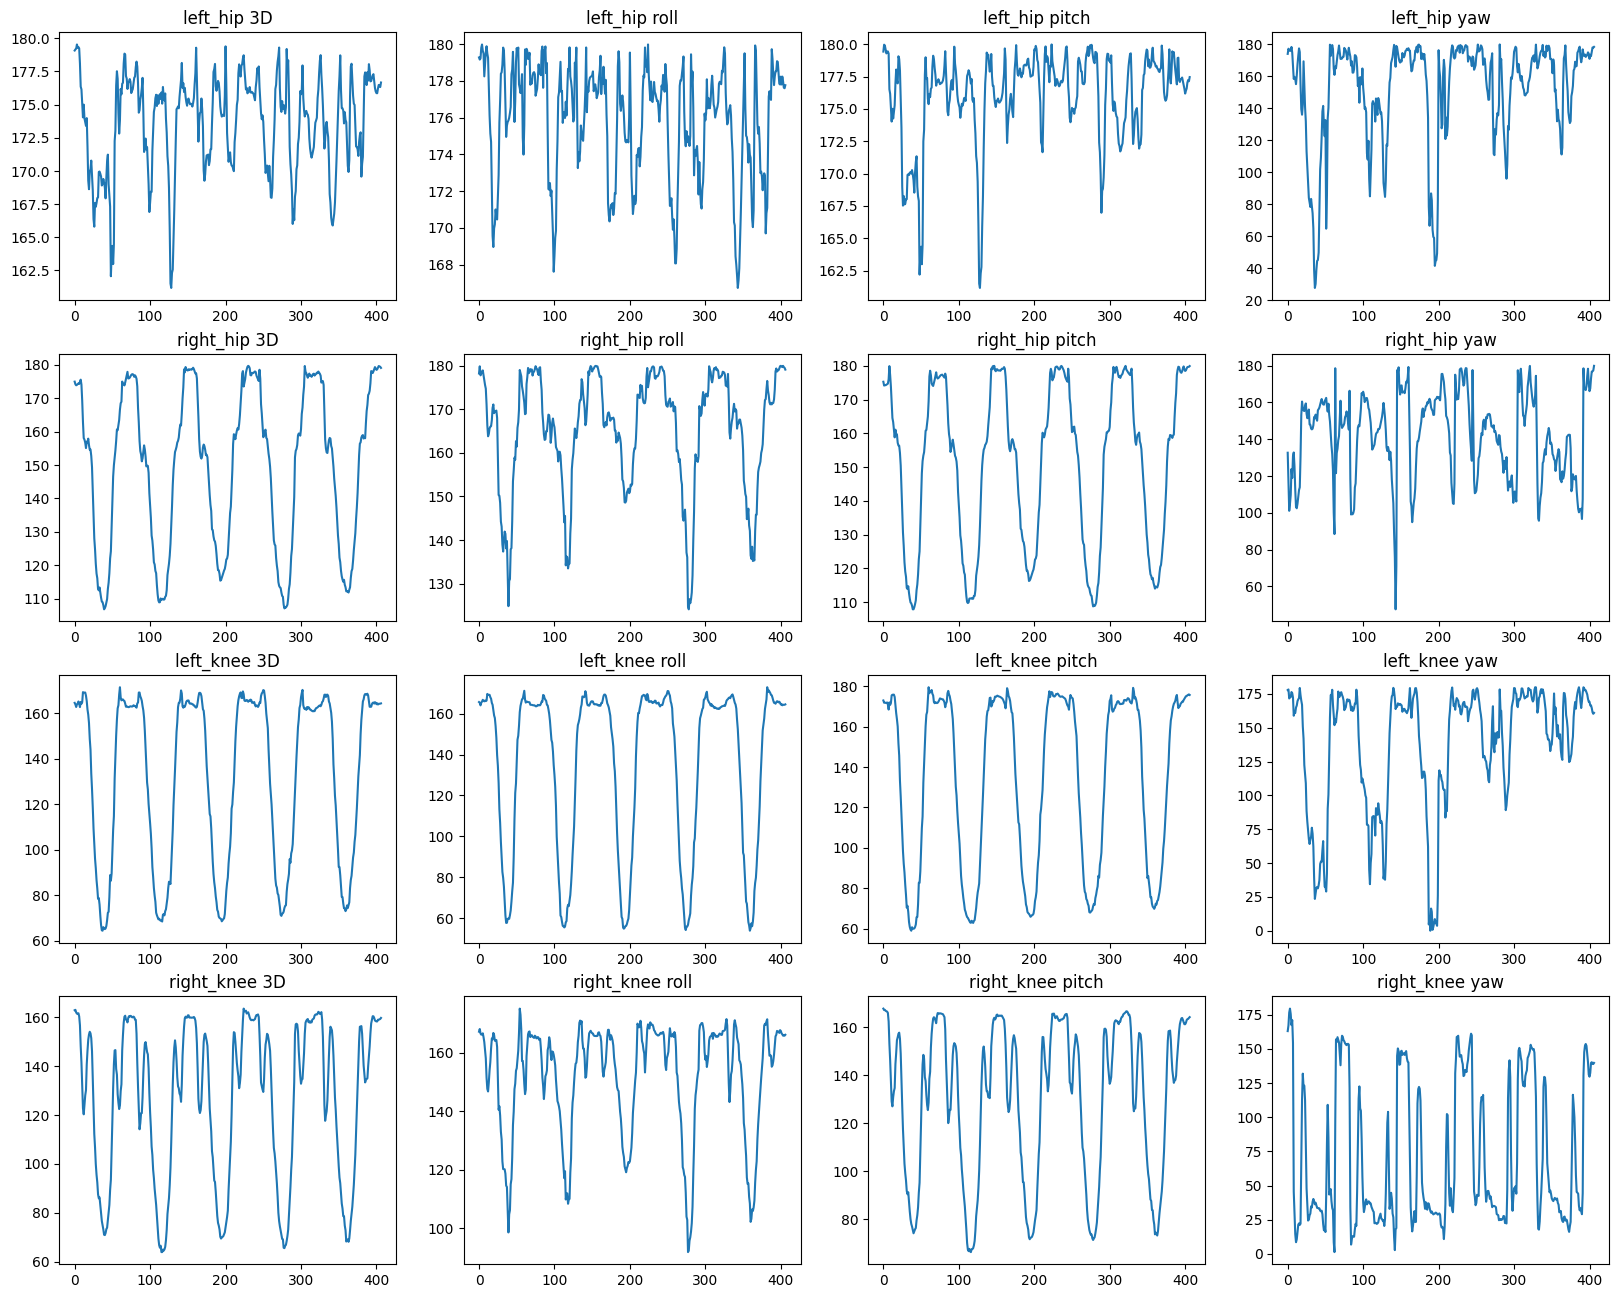

In [39]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 16))

angle_types = ["3D", "roll", "pitch", "yaw"]
squad_angles = ["left_hip", "right_hip", "left_knee", "right_knee"]

for angle, axes in zip(squad_angles, ax):
    for angle_type, axis in zip(angle_types, axes):
        axis.plot(query_squat[f"{angle}_{angle_type}"])
        axis.set_title(f"{angle} {angle_type}")

In [ ]:
from tslearn.metrics import dtw_path


def get_warped_frame_indexes(query: np.ndarray, reference: np.ndarray) -> list:
    path, _ = dtw_path(query, reference)
    path = np.array(path)
    return path


def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 16))


for angle, axes in zip(squad_angles, ax):
    for angle_type, axis in zip(angle_types, axes):
        angle_key = f"{angle}_{angle_type}"
        dtw_alignment = get_warped_frame_indexes(
            query_squat[angle_key], reference_squat[angle_key]
        )
        query_to_reference_warping = filter_repetable_reference_indexes(
            dtw_alignment[:, 1], dtw_alignment[:, 0]
        )

        diffs = [
            reference_squat[angle_key][reference_idx]-
            query_squat[angle_key][query_idx]
            for reference_idx, query_idx in enumerate(query_to_reference_warping)
        ]
        axis.plot(diffs)
        axis.set_title(f"DTW difference {angle_key}", fontsize=8)
        axis.set_xlabel("frame", fontsize=8)
        axis.set_ylabel("DTW angle diff", fontsize=8)
        